## Load libraries

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
## helper code found at https://github.com/tatwan/blog/blob/master/_notebooks/2020-05-21-part-2-train-model-DICOM.ipynb
## after file corruption. Model parameters, image augmentation, grad-cam implementation, most functions and all of the choices
## are mine. I don't know for sure if some parts left were not in the helper code. I implemented everything up to
## performance display before the corruption and I understand all the code.
## If by mistake I used code that was not in the base helper code, please signal it to me.
## I now make backups all the time so it won't happen again.


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

## General libraries
import seaborn as sns
from itertools import chain
import pydicom
from random import sample, uniform

## Scikit-Learn
from skimage.exposure import rescale_intensity
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, average_precision_score

## Keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
32647,00008523_002.png,No Finding,2,8523,64,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008523_002.png
7138,00001892_007.png,No Finding,7,1892,50,M,PA,2906,2837,0.143,0.143,NaN,/data/images_002/images/00001892_007.png
32184,00008420_001.png,No Finding,1,8420,57,F,PA,2048,2500,0.168,0.168,NaN,/data/images_004/images/00008420_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = list(set(list(chain.from_iterable([i.split('|') for i in all_xray_df['Finding Labels']]))))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Cardiomegaly,Pleural_Thickening,Nodule,Hernia,Pneumonia,Pneumothorax,Fibrosis,Edema,No Finding,Mass
85786,00021171_003.png,No Finding,3,21171,56,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
88018,00021772_015.png,No Finding,15,21772,62,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17600,00004746_016.png,No Finding,16,4746,41,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# We saw in the last part that some patients were over 150yo so let's remove them
# Also, we saw that Effusion intensity distribution was close to Pneumonia so we can try removing
# positive Effusion cases as well.
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]
all_xray_df = all_xray_df[all_xray_df['Effusion'] == 0]

In [5]:
# We might want to create a pneumonia_class column
all_xray_df['pneumonia_class'] = ['Pneumonia' if x==1 else 'No Pneumonia' for x in all_xray_df['Pneumonia']]
all_xray_df[all_xray_df['Pneumonia']==1].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Nodule,Hernia,Pneumonia,Pneumothorax,Fibrosis,Edema,No Finding,Mass,pneumonia_class
9562,00002484_003.png,Cardiomegaly|Pneumonia,3,2484,45,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pneumonia
50454,00012782_002.png,Infiltration|Pneumonia,2,12782,26,F,PA,2658,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pneumonia
42780,00011020_000.png,Pleural_Thickening|Pneumonia,0,11020,63,F,PA,2346,2991,0.143,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pneumonia


In [6]:
all_xray_df[all_xray_df['Pneumonia']==0].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Nodule,Hernia,Pneumonia,Pneumothorax,Fibrosis,Edema,No Finding,Mass,pneumonia_class
57657,00014290_001.png,Pneumothorax,1,14290,41,M,PA,2734,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia
3352,00000882_003.png,Atelectasis|Consolidation,3,882,60,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
51544,00013018_000.png,No Finding,0,13018,44,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No Pneumonia


## Create your training and testing data:

In [7]:
def create_splits(data, test_size=0.2, strat=None):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(data, 
                                            test_size = test_size, 
                                            stratify = data[strat],
                                            random_state=42)

    p_idx = train_data[train_data['Pneumonia']==1].index.tolist()
    np_idx = train_data[train_data['Pneumonia']==0].index.tolist()
    np_sample = sample(np_idx,len(p_idx))
    train_data = train_data.loc[p_idx + np_sample]
    
    p_idx = val_data[val_data['Pneumonia']==1].index.tolist()
    np_idx = val_data[val_data['Pneumonia']==0].index.tolist()
    np_sample = sample(np_idx,4*len(p_idx))
    val_data = val_data.loc[p_idx + np_sample]
    
    return train_data, val_data

In [8]:
# Pass our parameters to the function
train_df, val_df = create_splits(all_xray_df, 0.2, 'pneumonia_class')

In [9]:
len(train_df[train_df['Pneumonia']==1])/len(train_df), len(val_df[val_df['Pneumonia']==1])/len(val_df)

(0.5, 0.2)

(array([ 47.,  91., 194., 234., 267., 309., 377., 243.,  75.,  23.]),
 array([ 2. , 10.5, 19. , 27.5, 36. , 44.5, 53. , 61.5, 70. , 78.5, 87. ]),
 <a list of 10 Patch objects>)

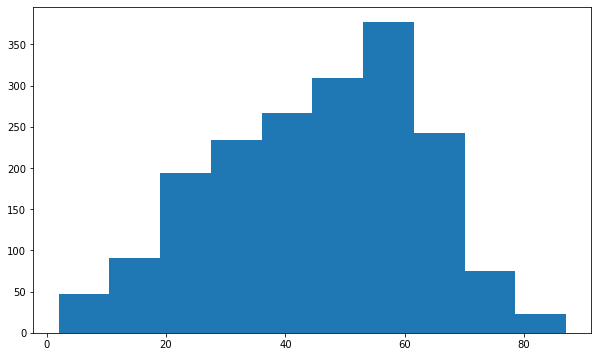

In [10]:
plt.figure(figsize=(10,6))
plt.hist(train_df['Patient Age'], bins=10)

(array([ 17.,  46., 122., 128., 165., 179., 229., 159.,  80.,  35.]),
 array([ 2. , 10.1, 18.2, 26.3, 34.4, 42.5, 50.6, 58.7, 66.8, 74.9, 83. ]),
 <a list of 10 Patch objects>)

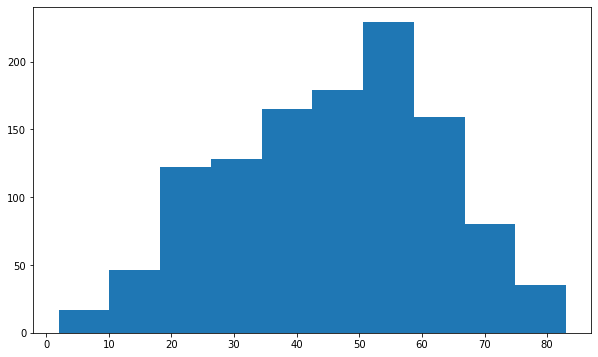

In [11]:
plt.figure(figsize=(10,6))
plt.hist(val_df['Patient Age'], bins=10)

(array([ 779.,    0., 1081.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

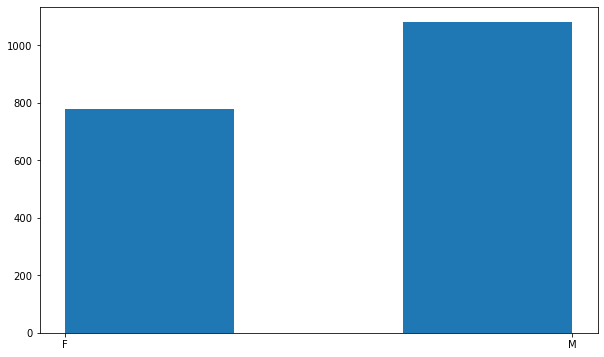

In [12]:
plt.figure(figsize=(10,6))
plt.hist(train_df['Patient Gender'], bins=3)

(array([645.,   0., 515.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

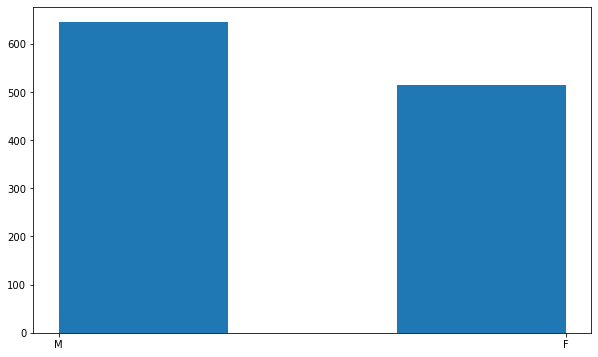

In [13]:
plt.figure(figsize=(10,6))
plt.hist(val_df['Patient Gender'], bins=3)

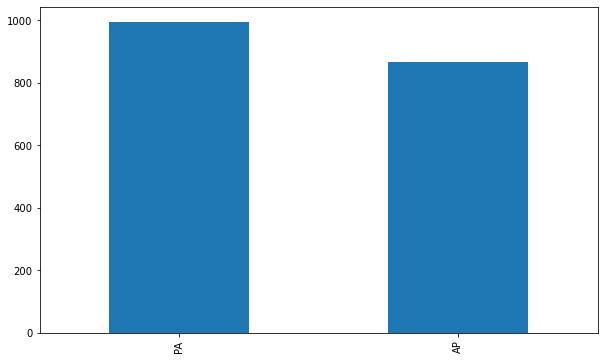

In [14]:
plt.figure(figsize=(10,6))
train_df['View Position'].value_counts().plot(kind='bar')

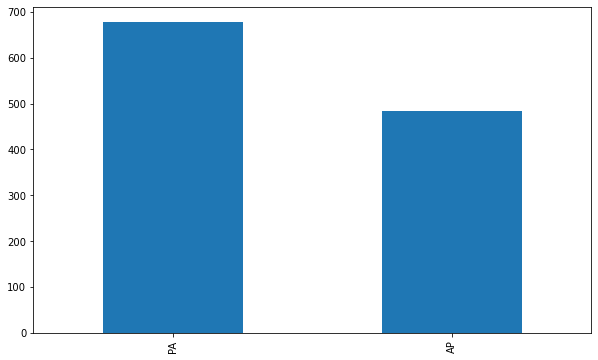

In [15]:
plt.figure(figsize=(10,6))
val_df['View Position'].value_counts().plot(kind='bar')

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [16]:
## This is the image size that VGG16 takes as input
IMG_SIZE = (224, 224)

In [17]:
## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
## built into something like a Keras package

# I implemented a contrast stretch with exposure.rescale_intensity
# got the template custom idg code from https://stepup.ai/custom_data_augmentation_keras/ (Jul 12, 2020)

class CustomDataGenerator(ImageDataGenerator):
    def __init__(self, rescale_factor=0, **kwargs):
        '''
        Custom image data generator.
        Behaves like ImageDataGenerator, but allows contrast stretching.
        '''
        super().__init__(preprocessing_function=self.contrast_stretch, **kwargs)
        self.rescale_factor = rescale_factor if (rescale_factor>=0 and rescale_factor<=100) else 0
    

    def contrast_stretch(self, image):
        '''Takes an input image and returns a modified version of it with rescaled intensity'''
        rand_rescale = uniform(0, self.rescale_factor)
        low_per, high_per = np.percentile(image, (rand_rescale, 100-rand_rescale))
        rescale_intensity(image, in_range=(low_per, high_per))
        return image

In [18]:
def my_image_augmentation(featurewise_center=False,
                          featurewise_std_normalization=False,
                          horizontal_flip=False, 
                          vertical_flip=False, 
                          height_shift_range=0,
                          width_shift_range=0,
                          rotation_range=0,
                          shear_range=0,
                          zoom_range=0,
                          rescale_factor=0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    img_aug = CustomDataGenerator(rescale=1. / 255.0,
                                  featurewise_center = featurewise_center,  # zero-meaning
                                  featurewise_std_normalization = featurewise_std_normalization,  # standardization
                                  horizontal_flip = horizontal_flip, 
                                  vertical_flip = vertical_flip, 
                                  height_shift_range= height_shift_range, 
                                  width_shift_range=width_shift_range, 
                                  rotation_range=rotation_range, 
                                  shear_range = shear_range,
                                  zoom_range=zoom_range,
                                  rescale_factor=rescale_factor)
    
    return img_aug


def make_train_gen(train_idg, train_df, x_col, y_col, target_size, batch_size):
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                              directory=None, 
                                              x_col = x_col,
                                              y_col = y_col,
                                              class_mode = 'binary',
                                              target_size = target_size, 
                                              batch_size = batch_size
                                             )
    return train_gen


def make_val_gen(val_idg, val_df, x_col, y_col, target_size, batch_size):

    val_gen = val_idg.flow_from_dataframe(dataframe = val_df, 
                                          directory=None, 
                                          x_col = x_col,
                                          y_col = y_col,
                                          class_mode = 'binary',
                                          target_size = target_size, 
                                          batch_size = batch_size)
    return val_gen

In [19]:
train_idg = my_image_augmentation(True, True, True, False, 0.1, 0.1, 15, 0.1, 0.1, 3)
val_idg = my_image_augmentation(True, True)

In [20]:
## Zero-meaning and standardization for better accuracy
img_sample = train_df['path'].sample(186)  # use 10% of the training dataset to fit the idg
train_arrays = []
for i in img_sample:
    img = plt.imread(i)
    if img.shape == (1024, 1024):
        train_arrays += [np.expand_dims(img, axis=2)]

train_arrays = np.array(train_arrays)  # fit the idg to be able to zero-mean the images
train_idg.fit(train_arrays)

In [21]:
## Same for validation data
img_sample = val_df['path'].sample(116)  # use 10% of the val dataset to fit the idg
val_arrays = []
for i in img_sample:
    img = plt.imread(i)
    if img.shape == (1024, 1024):
        val_arrays += [np.expand_dims(img, axis=2)]
        
val_arrays = np.array(val_arrays)  # fit the idg to be able to zero-mean the images
val_idg.fit(val_arrays)

In [22]:
train_gen = make_train_gen(train_idg=train_idg,
                           train_df=train_df,
                           x_col='path',
                           y_col='pneumonia_class',
                           target_size=IMG_SIZE,
                           batch_size=32)
val_gen = make_val_gen(val_idg, val_df, 'path', 'pneumonia_class', IMG_SIZE, 32)

Found 1860 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.


In [23]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

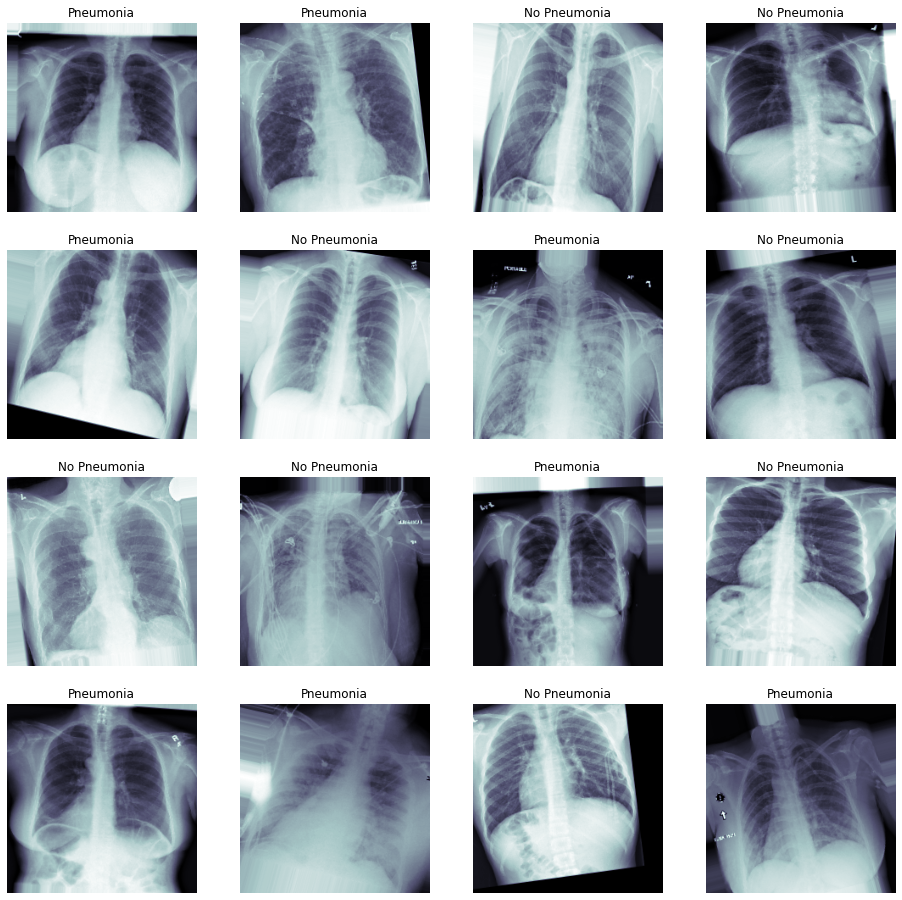

In [24]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [25]:
model = VGG16(include_top=True, weights='imagenet')

In [26]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[:-2]:
        layer.trainable = False
    
    return vgg_model


In [28]:
vgg_model = load_pretrained_model()

In [29]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [30]:
def build_my_model(pre_trained):
    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above, but layer by layer.
    # This also copies the weights, I want to get rid of the submodel for better clarity
    
    for ix in range(0, 19):
        curr_layer = pre_trained.get_layer(index=ix)
        # copy this layer over to the new model
        my_model.add(curr_layer)

    my_model.add(Flatten())
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.


    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))

    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))

    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))

    # Final output layer

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='sigmoid'))

    return my_model


In [31]:
model = build_my_model(vgg_model)

In [32]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
model.get_layer(index=0)

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [35]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model2.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [36]:
history = model.fit(train_gen, validation_data=[valX, valY], epochs=30, callbacks=callbacks_list )

Epoch 1/30
59/59 [==============================] - 56s 946ms/step - loss: 0.8126 - binary_accuracy: 0.5425 - val_loss: 0.7554 - val_binary_accuracy: 0.4688

Epoch 00001: val_loss improved from inf to 0.75540, saving model to xray_class_my_model2.best.hdf5
Epoch 2/30
59/59 [==============================] - 53s 899ms/step - loss: 0.6742 - binary_accuracy: 0.6054 - val_loss: 0.6090 - val_binary_accuracy: 0.7812

Epoch 00002: val_loss improved from 0.75540 to 0.60902, saving model to xray_class_my_model2.best.hdf5
Epoch 3/30
59/59 [==============================] - 54s 915ms/step - loss: 0.6531 - binary_accuracy: 0.6177 - val_loss: 0.4105 - val_binary_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.60902 to 0.41052, saving model to xray_class_my_model2.best.hdf5
Epoch 4/30
59/59 [==============================] - 53s 900ms/step - loss: 0.6506 - binary_accuracy: 0.6430 - val_loss: 0.4640 - val_binary_accuracy: 0.7188

Epoch 00004: val_loss did not improve from 0.41052
Epoch 5/30
5

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

## To tweak my model, here is how I picked my parameters:
- image augmentation: I picked the classic idg settings without vertical flips, reduced the rotation to 15 because 20 looked too much. I then searched for other types of data augmentation and found about contrast manipulation. It felt interesting because some images looked sharper than others so I implemented a CustomDataGenerator to add the skimage rescale_intensity method, and picked the percentiles to adjust the intensity with to be 3 and 97 because I did not want to completely alter the input data. (also ran a few tests and 5, 95 already had bad val_loss)
- batch size: I wanted to set this parameter first and then tweak the rest around it. I saw that 32, 64 and 128 are advised and I tried them all. The higher it was, the more I observed that the model would learn very quickly in the first epochs and then wouldn't get better at all. I chose to go with 32 for steadier improvements.
- learning rate: I originally chose other optimizers such as Adadelta or Adagrad and set the learning rate around 1e-4 when required. I later went back to Adam and found that the learning rate was then too low and the model wasn't really training so I set it back to 1e-3 and got decent results.
- model architecture: I did not experiment much with the architecture as I got poor results with other architectures. So, I picked the architecture used in class and played with the dropout, but I couldn't observe a difference with the dropout between 0.4 and 0.6, so I put it back to 0.5.

In [37]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 12ms/step


In [38]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


## Grad-CAM implementation to understand the output of the last conv layer
## Modified code from https://github.com/eclique/keras-gradcam (last update on 7 Oct 2019)
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = load_img(path, target_size=IMG_SIZE)
    if preprocess:
        x = img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def grad_cam(input_model, image, layer_name):
    """GradCAM method for visualizing input saliency."""
    conv_output = input_model.get_layer(layer_name).get_output_at(1)  # get_output_at(0) after model load
    y_c = input_model.output[0, 0]  # input_model.get_layer('model_1').output[:] #  + 
    grads = K.gradients(y_c, conv_output)[0]

    # Normalize if necessary
    grads = normalize(grads)

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = resize(cam, IMG_SIZE)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_saliency(model, predictions, imgs, index, layer_name):
    """Compute saliency for the highest probability of each class ('Penumonia' & 'No Pneumonia').
        -index: which image to do the grad-cam on
        -layer_name: layer to compute gradients
    """
    preprocessed_input = np.expand_dims(imgs[index], axis=0)
    pred_prob = predictions[index][0]
    if pred_prob > 0.5:  # base threshold for most probable prediction
        pred_class = 'Pneumonia'
    else:
        pred_class = 'No Pneumonia'
        pred_prob = 1 - pred_prob
    print('Model prediction:')
    print('\t{}\t with probability {:.3f}'.format(pred_class, pred_prob))
    print("Explanation for '{}'".format(pred_class))

    gradcam = grad_cam(model, preprocessed_input, layer_name)

    plt.figure(figsize=(15, 10))
    plt.title('GradCAM')
    plt.axis('off')
    plt.imshow(imgs[index])  # load_image(img_path, preprocess=False))
    plt.imshow(gradcam, cmap='jet', alpha=0.5)
    plt.show()

Model prediction:
	Pneumonia	 with probability 0.814
Explanation for 'Pneumonia'


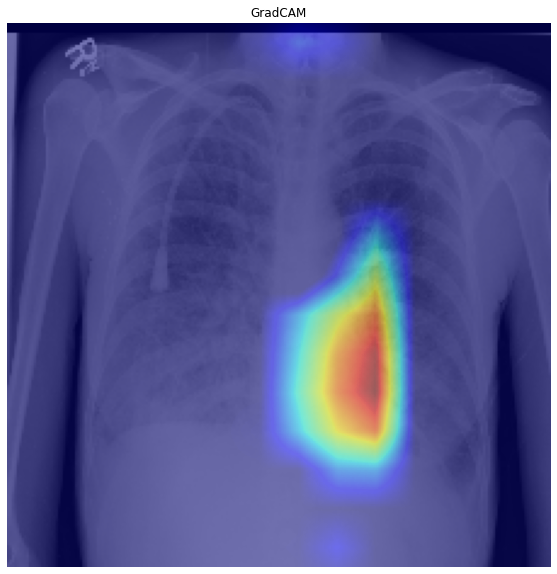

In [49]:
## I tried GRAD CAMs, not sure this is working though, as I compute saliency after batch predictions
## Maybe I should compute it after only one prediction
# GRAD-CAM for the most probable 'Pneumonia' case
max_index = np.argmax(pred_Y)
compute_saliency(my_model, pred_Y, valX, max_index, layer_name='block5_conv3')

Model prediction:
	No Pneumonia	 with probability 0.944
Explanation for 'No Pneumonia'


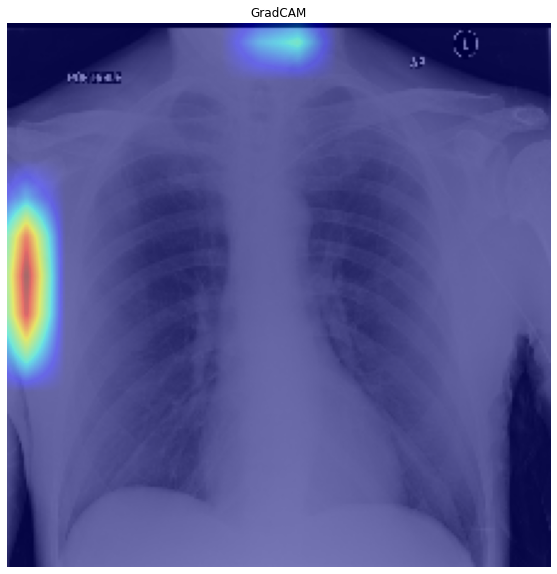

In [45]:
# GRAD-CAM for the most probable 'Non Pneumonia' case
min_index = np.argmin(pred_Y)
compute_saliency(my_model, pred_Y, valX, min_index, layer_name='block5_conv3')

In [38]:
def plot_auc(t_y, p_y):
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC? 
def plot_precision_recall(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


#Also consider plotting the history of your model training:
def plot_history(history):
    plt.plot(history.history['loss'], label='train_loss', color='skyblue')
    plt.plot(history.history['val_loss'], label='val_loss', color='red')
    plt.plot(history.history['binary_accuracy'], label='binary_accuracy', color='purple')
    plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy', color='green')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

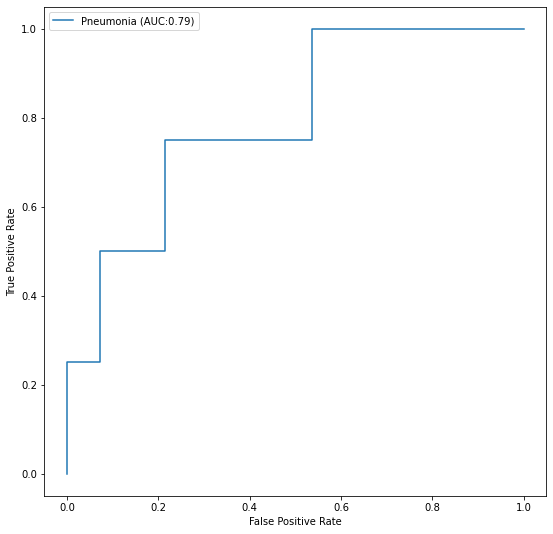

In [39]:
## plot figures
plot_auc(valY, pred_Y)

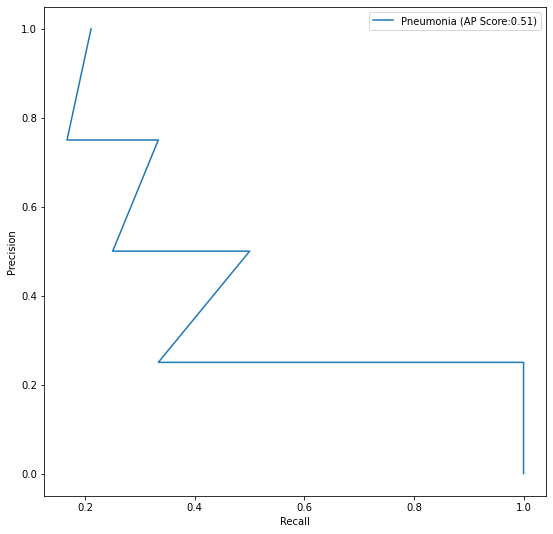

In [40]:
plot_precision_recall(valY, pred_Y)

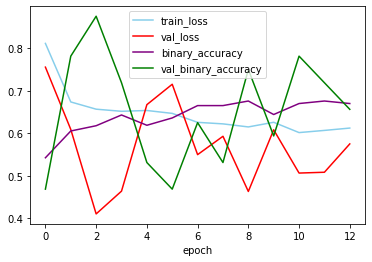

In [41]:
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [42]:
val_gen = make_val_gen(val_idg, val_df, 'path', 'pneumonia_class', IMG_SIZE, 100)
valX, valY = val_gen.next()

Found 1160 validated image filenames belonging to 2 classes.


In [43]:
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

100/100 [==============================] - 1s 10ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


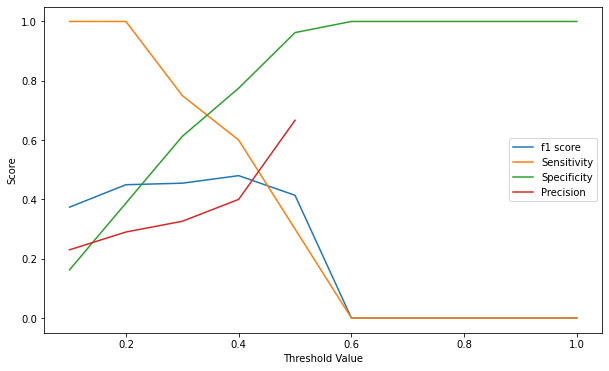

In [44]:
# Test for different threshold levels
# using colors just to make it easir to read and spot numbers
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sens = []
spec = []
prec = []
fscore = []
for t in thresholds:
    pred_Y_binary = [1 if i[0] > t else 0 for i in pred_Y]
    tn, fp, fn, tp = confusion_matrix(valY, pred_Y_binary).ravel()
    sens.append(tp/(tp+fn))
    spec.append(tn/(tn+fp))
    prec.append(tp/(tp+fp))
    fscore.append(f1_score(valY, pred_Y_binary))

plt.figure(figsize=(10,6))
plt.plot(thresholds, fscore, label='f1 score')
plt.plot(thresholds, sens, label='Sensitivity')
plt.plot(thresholds, spec, label='Specificity')
plt.plot(thresholds, prec, label='Precision')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.show()

In [45]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

THRESHOLD = 0.4  # Low threshold seems to be good for sensitivity AND specificity, has the highest f1 score

#  Maybe this threshold works specifically with a particular set of images though

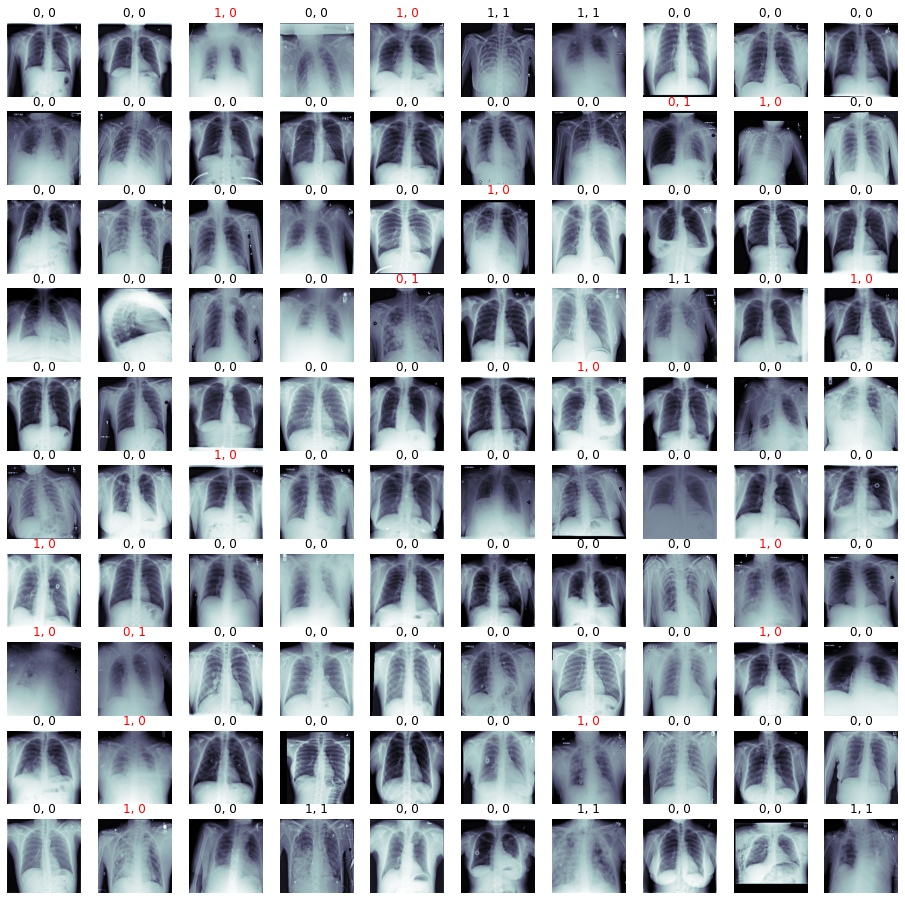

In [46]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.5:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0', color='red')
    else:
        if pred_Y[i] > 0.5: 
            c_ax.set_title('0, 1', color='red')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [47]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

Model prediction:
	Pneumonia	 with probability 0.787
Explanation for 'Pneumonia'


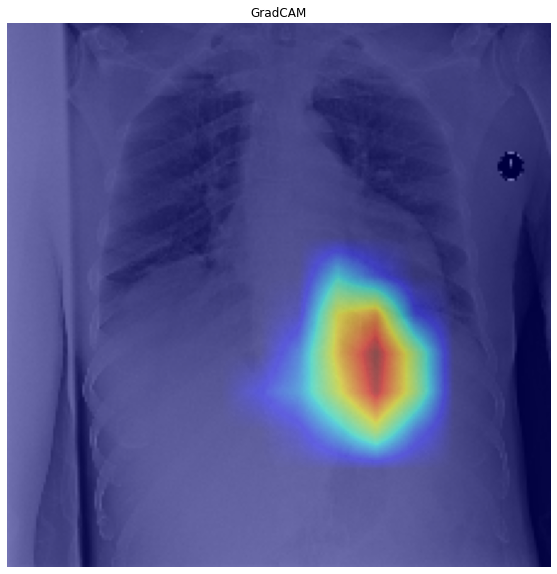

In [28]:
## OTHER GRAD-CAMs from other prediction sets
# GRAD-CAM for the most probable 'Pneumonia' case
max_index = np.argmax(pred_Y)
compute_saliency(my_model, pred_Y, valX, max_index, layer_name='block5_conv3')

Model prediction:
	No Pneumonia	 with probability 0.949
Explanation for 'No Pneumonia'


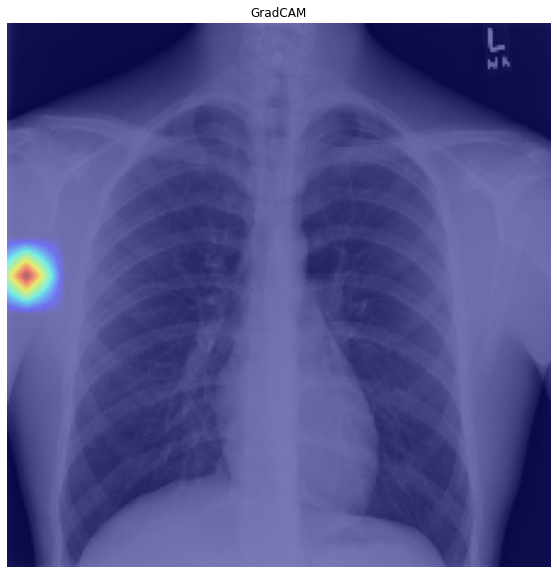

In [48]:
## The 'No Pneumonia' seems to focus on the same part on the left for some reason
# GRAD-CAM for the most probable 'Non Pneumonia' case
min_index = np.argmin(pred_Y)
compute_saliency(my_model, pred_Y, valX, min_index, layer_name='block5_conv3')